In [1]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from os import listdir
from os.path import join

import deepcoloring as dc

%matplotlib inline
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [52]:
!wget https://www.dropbox.com/s/giwn4yl2i85htkw/ecoli_model.t7 -O model.t7

--2018-07-30 11:09:27--  https://www.dropbox.com/s/giwn4yl2i85htkw/ecoli_model.t7
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.1, 2620:100:6022:1::a27d:4201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/giwn4yl2i85htkw/ecoli_model.t7 [following]
--2018-07-30 11:09:27--  https://www.dropbox.com/s/raw/giwn4yl2i85htkw/ecoli_model.t7
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6fe163539a717a605d1260d1b4.dl.dropboxusercontent.com/cd/0/inline/AMpJwR7vjSkdJEI_N9iWpLu5yEJ-6g-Tf5je8xuqszIBgjUaSphCXxM4ddKfoK77j-h0bm50cKCG2Wf3Nc7pk-AcW3b0KmsV1BTWurgx78_IihZGYZMkl0g5SezfIffYibSVJMI_0E_IoRhYyrK5XQGrd18EOMohl6rG5tZkFt9g09RInFWieBd4TTg8tmLSuvw/file [following]
--2018-07-30 11:09:27--  https://uc6fe163539a717a605d1260d1b4.dl.dropboxusercontent.com/cd/0/inline/AMpJwR7vjSkdJEI_N9iWpLu5yEJ-6g-Tf5je8xuqsz

In [2]:
net = dc.EUnet(1,6,k=2,s=4,depth=3,l=1, padding=0, use_dropout=True).to(device)
net.load_state_dict(torch.load("model.t7"))

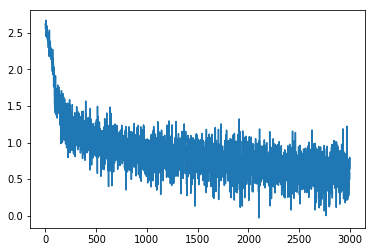

In [3]:
plt.plot(np.log(np.loadtxt("model.txt")))

(<matplotlib.figure.Figure at 0x7f6bd0c26910>,
 <matplotlib.figure.Figure at 0x7f6b5b52bbd0>)

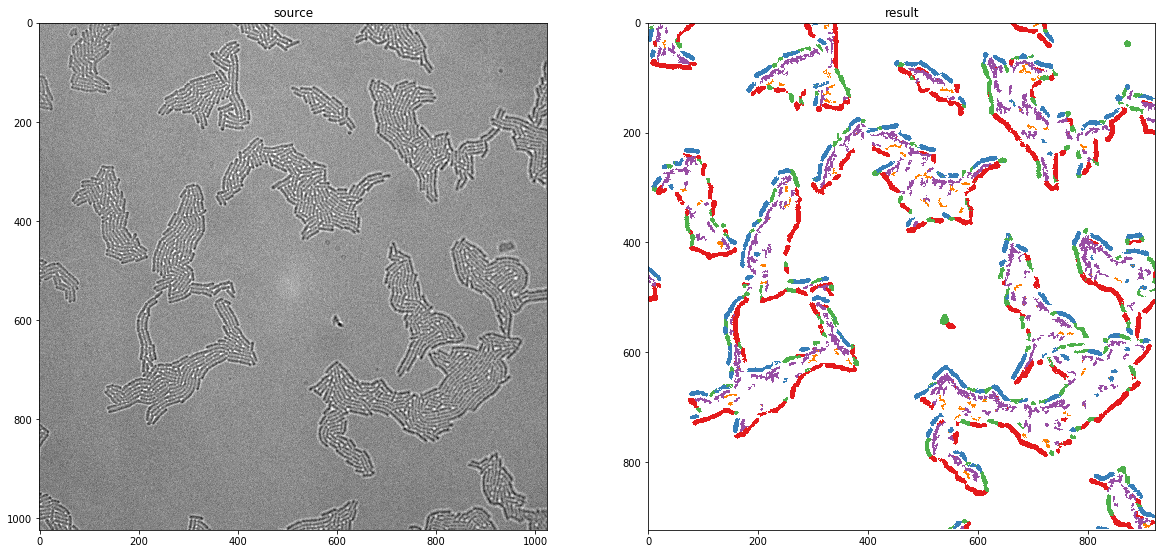

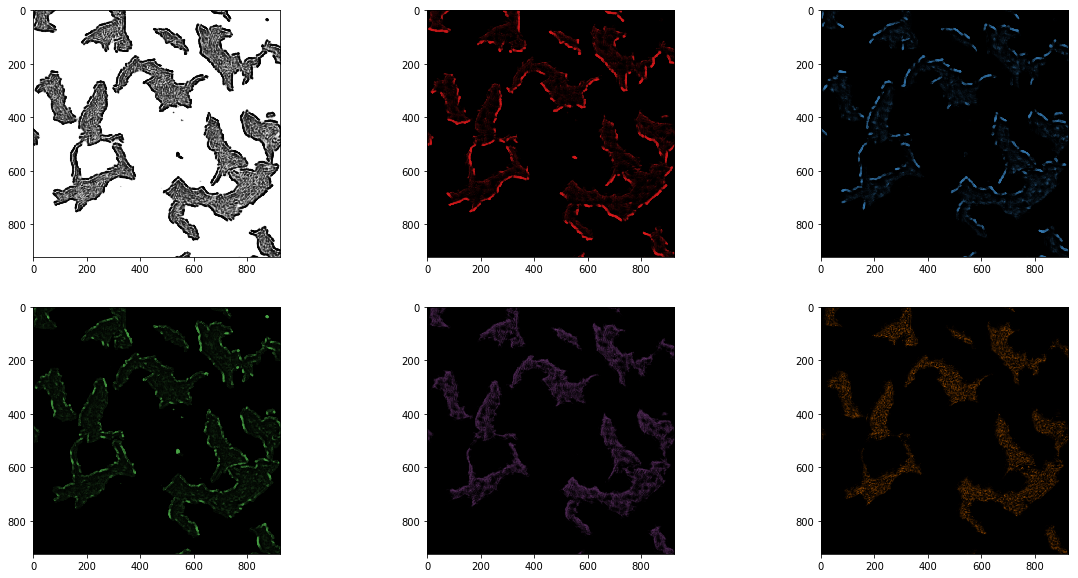

In [4]:
from skimage.io import imread
xo = imread("../images/ecoli31_rgb.png")[:,:,0]

x = dc.normalize(128., 128., )(xo, True)
x = np.expand_dims(x, 0)

vx = torch.from_numpy(np.expand_dims(x, 0)).float().to(device)
p = net(vx)
p_numpy = p.detach().cpu().numpy()[0]
dc.visualize(xo,p_numpy,40,draw_text=False)

In [5]:
basepath = "/media/hpc-4_Raid/vkulikov/Microscopy/Ecoli/ecoli_plus"

rgb = sorted([join(basepath, f) for f in listdir(basepath) if f.endswith('_rgb.png')])
labels = sorted([join(basepath, f) for f in listdir(basepath) if f.endswith('_label.png')])
# Check the names are paired correctly
assert np.array([img[:-7] == lbl[:-9] for img, lbl in zip(rgb, labels)]).all() == True

np.random.seed(1203412412)
indexes = np.random.permutation(len(rgb))
perm_rgb = np.array(rgb)[indexes].tolist()
perm_labels = np.array(labels)[indexes].tolist()

train_data = dc.Reader(perm_rgb[:-10], perm_labels[:-10], 1)
valid_data = dc.Reader(perm_rgb[-10:], perm_labels[-10:], 1)

In [17]:
print(x.dtype, y.dtype)
print(x.max(),x.min())
transforms = [dc.clip_patch((256, 256)),
                  dc.flip_horizontally(),
                  dc.flip_vertically(),
                  dc.rotate90(),
                  dc.rgb2gray(),
                  dc.normalize(0.5, 0.5)]

generator = train_data.create_batch_generator(40, transforms=transforms)
mask_builder = dc.build_halo_mask(fixed_depth=100,margin=35,min_fragment=10)

(dtype('float32'), dtype('int32'))
(-0.9921875, -1.0)


In [18]:
x,y = generator()
print(x.dtype, y.dtype)
print(x.max(),x.min())

(dtype('float32'), dtype('int32'))
(1.0, -1.0)


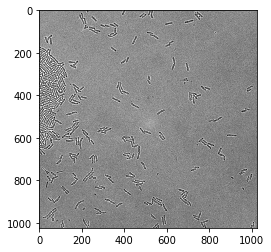

In [6]:
x,y = train_data[0]
plt.imshow(x)

In [14]:
def clip_mask_builder(builder, size=256, target=96):
    padding_shift = (size - target) / 2

    def func(y):
        return builder(y[:, padding_shift:padding_shift + target, padding_shift:padding_shift + target])
    return func

transforms = [dc.clip_patch((256, 256)),
              dc.flip_horizontally(),
              dc.flip_vertically(),
              dc.rotate90(),
              dc.rgb2gray(),
              dc.normalize(128., 128.)]

generator = train_data.create_batch_generator(40, transforms=transforms)
mask_builder = clip_mask_builder(dc.build_halo_mask(fixed_depth=100,margin=35,min_fragment=10))

In [1]:
a,b = generator()
l,w,o = mask_builder(b)

NameError: name 'generator' is not defined

[0 1 2 3 4]


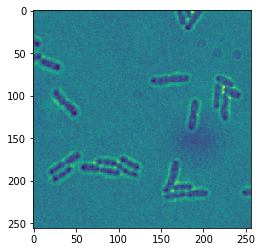

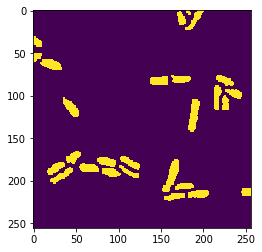

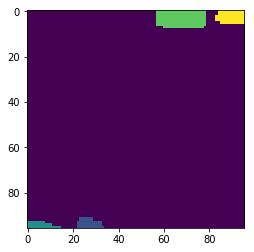

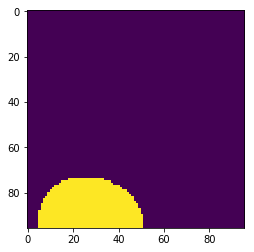

In [67]:
k=31
plt.imshow(a[k,0])
plt.figure()
plt.imshow(b[k]>0)
plt.figure()
plt.imshow(np.argmax(l[k],0))
plt.figure()
plt.imshow(w[k,1])
print(o[k])

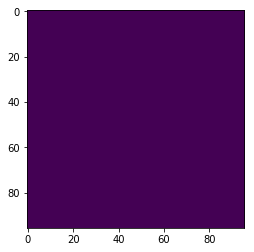

In [38]:
plt.imshow(np.argmax(w[0],0))

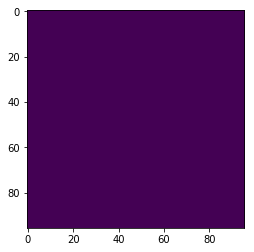

In [45]:
plt.imshow(w[0,4])